In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Print columns for the "measurement" table
print(measurement.__table__.columns)

ImmutableColumnCollection(measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs)


In [10]:
# Print columns for the "station" table
print(station.__table__.columns)

ImmutableColumnCollection(station.id, station.station, station.name, station.latitude, station.longitude, station.elevation)


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
most_recent

'2017-08-23'

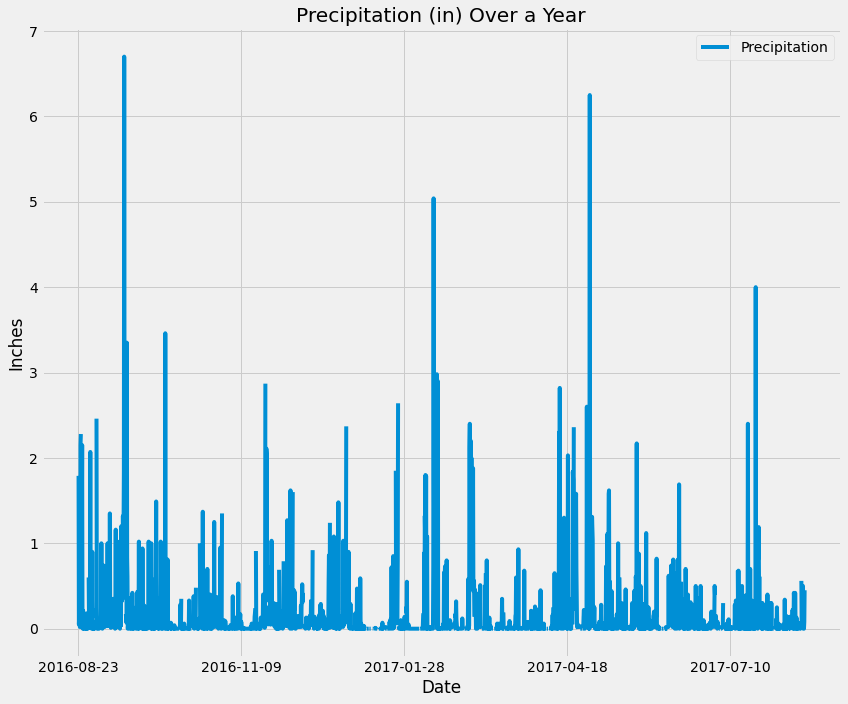

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_dt = (dt.datetime.strptime(most_recent, "%Y-%m-%d")).date()
most_recent_dt

# Calculate the date one year from the last date in data set.
year_ago = most_recent_dt - dt.timedelta(days = 365)
year_ago

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(measurement.date, measurement.prcp).\
    filter((measurement.date >=year_ago) & (measurement.date <= most_recent_dt)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation, columns=["Date", "Precipitation"])
precipitation_df.set_index("Date",inplace=True)

# Sort the dataframe by date
precipitation_df.sort_values("Date",inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(figsize=(12,10))
plt.title(f"Precipitation (in) Over a Year")
plt.xlabel("Date")
plt.ylabel("Inches")

plt.tight_layout()
plt.savefig("Precipitation.png")
plt.show()



In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(station).count()
print(total_stations)

9


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_list = session.query(measurement.station, func.count(measurement.station)).order_by(func.count(measurement.station).desc()).group_by(measurement.station).all()

most_active_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_sta = most_active_list[0][0]
print(f'The most active station is {most_active_sta}. See below for stats:')

# Lowest Temperature
lo_temp = session.query(func.min(measurement.tobs)).\
    filter(measurement.station == most_active_sta).scalar()
print(f' * Lowest Temperature = {lo_temp} degrees (F)')

# Highest Temperature
hi_temp = session.query(func.max(measurement.tobs)).\
    filter(measurement.station == most_active_sta).scalar()
print(f' * Highest Temperature = {hi_temp} degrees (F)')
      
# Average Temperature 
avg_temp = session.query(func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_sta).scalar()
avg_temp = round(avg_temp, 1)
print(f' * Average Temperature = {avg_temp} degrees (F)')

The most active station is USC00519281. See below for stats:
 * Lowest Temperature = 54.0 degrees (F)
 * Highest Temperature = 85.0 degrees (F)
 * Average Temperature = 71.7 degrees (F)


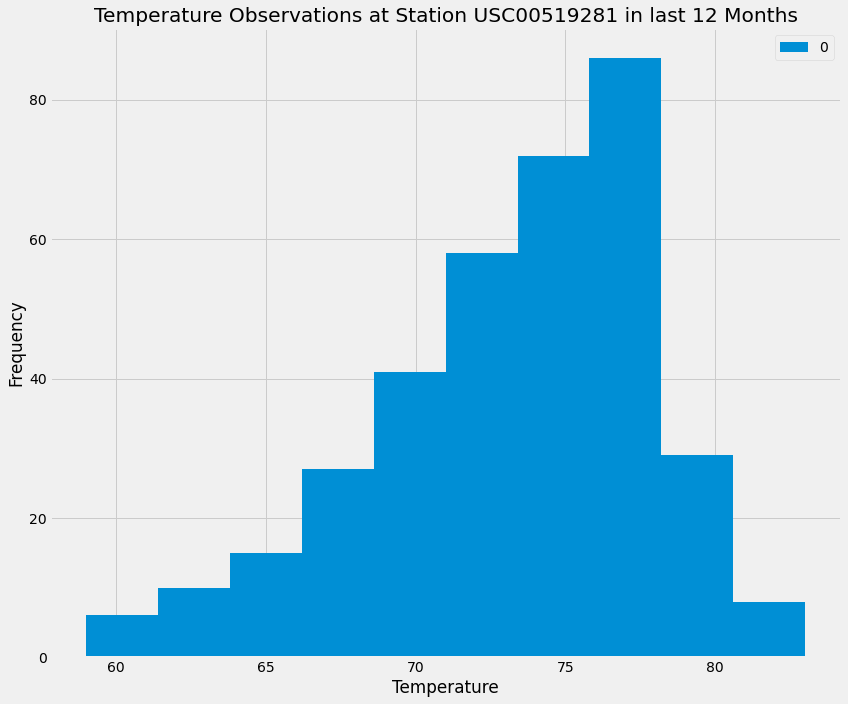

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_sta_tob = pd.DataFrame(session.query(measurement.tobs).\
    filter((measurement.station == most_active_sta)\
          & (measurement.date >= year_ago) & (measurement.date <= most_recent_dt)))

# Display dataframe
most_active_sta_tob

most_active_sta_tob.plot(kind='hist', figsize=(12,10), bins=10)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations at Station {most_active_sta} in last 12 Months')

plt.tight_layout()
plt.savefig('hist_temp_obs_most_active_station.png')
plt.show()

# Close session

In [18]:
# Close Session
session.close()